# `scippr` inference module

This notebook outlines the `scippr` inference procedure based on hierarchical inference.  To improve performance, all probabilities will be calculated as log probabilities.

In [63]:
import numpy as np
import astropy.cosmology as cosmology
import scipy.optimize as spo
import scipy.stats as sps
from scipy.stats import norm
from scipy.interpolate import interp1d
import scipy.linalg as la
import emcee
import corner
from datetime import datetime
import pickle
import bisect
import daft
import cProfile
import StringIO
import pstats

import os
paths = ['data', 'plots']
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

import sys
epsilon = sys.float_info.min
log_epsilon = sys.float_info.min_exp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
colors = 'rbgcymk'

2.22507385851e-308
-1021


`scippr` is based on a probabilistic graphical model, illustrated below.  The model has two types of observables, shown in shaded circles, supernova lightcurves $\underline{\ell}_{n}$ and host galaxy photometry $\vec{f}_{n}$.  The parameters, which are by definition not directly observable, are shown in empty circles.  The latent variables of supernova type $t_{n}$, redshift $z_{n}$, and distance modulus $\mu_{n}$ are parameters over which we will marginalize, without ever directly inferring them, and while all three of them influence $\underline{\ell}_{n}$, only $z_{n}$ affects $\vec{f}_{n}$ in this model.  In other words, _we currently assume no relationship between supernova type and host galaxy photometry, an assumption we may revisit in the future_.  The selection function parameters $\vec{\psi}$ and $\vec{\zeta}$ are known constants of the survey symbolized by dots that influence the possible lightcurves and host galaxy photometry that are included in the sample.  The box indicates that the latent variables and the observables are generated independently $N$ times for each supernova in the sample.  The hyperparameters we would like to estimate are the redshift-dependent supernova type proportions $\underline{\phi}$ that determine $t_{n}$ and $z_{n}$ and the cosmological parameters $\vec{\Omega}$ that relate $z_{n}$ to $\mu_{n}$, which are shared by all $N$ supernovae in the observed sample.  

/Users/christinapeters/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


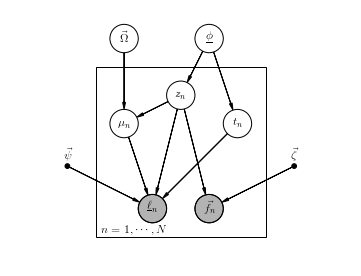

In [2]:
#initialize the PGM
pgm = daft.PGM([6, 4.5], origin=[0, 0])

#desired hyperparameters
pgm.add_node(daft.Node("cosmology", r"$\vec{\Omega}$", 2., 4.))
pgm.add_node(daft.Node("dist", r"$\underline{\phi}$", 3.5, 4.))
#pgm.add_node(daft.Node("rates", r"$\vec{R}$", 3., 5.5, fixed=True))

#latent variables/parameters
pgm.add_node(daft.Node("distance", r"$\mu_{n}$", 2., 2.5))
pgm.add_node(daft.Node("redshift", r"$z_{n}$", 3., 3.))
pgm.add_node(daft.Node("type", r"$t_{n}$", 4., 2.5))

#data
pgm.add_node(daft.Node("lightcurve", r"$\underline{\ell}_{n}$", 2.5, 1., observed=True))
pgm.add_node(daft.Node("photometry", r"$\vec{f}_{n}$", 3.5, 1., observed=True))

#known constant parameters
pgm.add_node(daft.Node("lightcurve selection", r"$\vec{\psi}$", 1., 1.75, fixed=True))
pgm.add_node(daft.Node("photometry selection", r"$\vec{\zeta}$", 5., 1.75, fixed=True))

# Add in the edges.
pgm.add_edge("dist", "type")
pgm.add_edge("cosmology", "distance")
pgm.add_edge("dist", "redshift")
pgm.add_edge("redshift", "distance")
#pgm.add_edge("distance", "photometry")
pgm.add_edge("distance", "lightcurve")
pgm.add_edge("redshift", "photometry")
pgm.add_edge("redshift", "lightcurve")
pgm.add_edge("type", "lightcurve")
pgm.add_edge("photometry selection", "photometry")
pgm.add_edge("lightcurve selection", "lightcurve")

# plates
pgm.add_plate(daft.Plate([1.5, 0.5, 3., 3.], label=r"$n = 1, \cdots, N$"))

# Render and save.
pgm.render()
pgm.figure.show()
pgm.figure.savefig('plots/inf_pgm.png', dpi=500)

The probabilistic graphical model will guide us in characterizing the posterior distribution $\ln[p(\vec{\theta}, \underline{\phi} | \{\underline{\ell}_{n}, \vec{m}_{n}\}_{N})]$ of the hyperparameters given the observed data, but as a sneak preview, this is the form it will take:

\begin{align}
\ln[p(\vec{\theta}, \underline{\phi} | \{\underline{\ell}_{n}, \vec{m}_{n}\}_{N})] \propto & \ln[p(\vec{\theta}, \underline{\phi})]\\
& +\sum_{n}^{N}\ \ln[\iiint\ \exp[\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{m}_{n}, \underline{\xi}, \vec{\psi}, \vec{\zeta})] + \ln[p(t_{n}, z_{n}, \mu_{n} | \vec{\theta}, \underline{\phi})]\\
\ \ \ \ \ & - \ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\xi}) - \ln[p(t_{n}, z_{n}, \mu_{n} | \vec{\psi}, \vec{\zeta})]]\ d\mu_{n}\ dz_{n}\ dt_{n}]
\end{align}

## Setting up the parameter space

First we set up the parameter space for the latent variables of supernova type $t$, redshift $z$, and distance modulus $\mu$.

In [165]:
if not os.path.exists('data'):
    print('ERROR: No data to read in!  Run the simulation notebook first.')
else:
    with open('data/data.hkl', 'r+') as in_file:
        sim_info = pickle.load(in_file)

if not os.path.exists('data'):
    print('ERROR: No data to read in!  Run the simulation notebook first.')
else:
    with open('data/truth.hkl', 'r+') as in_file:
        truth_info = pickle.load(in_file)

true_data = truth_info['data']
true_zs = [true_param['z'] for true_param in true_data]
true_mus = [true_param['mu'] for true_param in true_data]

types = sim_info['types']
n_types = len(types)

z_bins = sim_info['z_bins']
z_difs = z_bins[1:] - z_bins[:-1]
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.
n_zs = len(z_difs)

mu_bins = sim_info['mu_bins']
mu_difs = mu_bins[1:] - mu_bins[:-1]
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.
n_mus = len(mu_difs)

z_mu_grid = np.array([[(z, mu) for mu in mu_mids] for z in z_mids])

def safe_log(arr, threshold=epsilon):
    arr[arr < threshold] = threshold
    return np.log(arr)

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

pmin, pmax = log_epsilon, np.log(1./(min(z_difs) * min(mu_difs)))

In [157]:
lninterimposteriors = sim_info['interim ln posteriors']
n_SNe = len(lninterimposteriors)

true_types = [true_param['t'] for true_param in true_data]
type_converter = {'Ia': 0, 'Ibc': 1, 'II': 2}
true_types_indices = [type_converter[m] for m in true_types]

type_tmp=np.zeros((n_SNe,3))
type_tmp[:,:] =np.dot(np.dot(np.exp(lninterimposteriors[:,:,:,:]),mu_difs), z_difs)
obs_type = np.argmax(type_tmp, axis=1)

muerr_lo = np.zeros((n_SNe, n_types))
muerr_hi = np.zeros((n_SNe, n_types))

zerr_lo = np.zeros((n_SNe, n_types))
zerr_hi = np.zeros((n_SNe, n_types))

xy = np.empty((2, n_SNe, n_types))

two_sigma_percentiles = [0.0228,0.5,0.9772]

for sn in range(n_SNe):
    for tn in range(n_types):
        zm = lninterimposteriors[sn, tn, :, :]
        hm = lninterimposteriors[sn, tn, :, :].T
        
        z_prob  = np.dot(np.exp(zm), mu_difs[:])
        mu_prob = np.dot(np.exp(hm), z_difs)
        
        xy[0][sn][tn] = z_bins[np.argmax(z_prob)]
        xy[1][sn][tn] = mu_bins[np.argmax(mu_prob)]
        
        z_prob   = np.dot(np.exp(zm), mu_difs[:])
        tot_prob = np.sum(z_prob)
        cum_prob = np.array([])
        for i in range(len(z_bins)):
            cum_prob = np.append(cum_prob, np.sum(z_prob[:i])/tot_prob)
        zspline = interp1d(cum_prob, z_bins)
        zlow,zmed,zhigh = zspline(two_sigma_percentiles)
        
        mu_prob  = np.dot(np.exp(hm),z_difs)
        tot_prob = np.sum(mu_prob)
        cum_prob = np.array([])
        for i in range(len(mu_bins)):
            cum_prob = np.append(cum_prob, np.sum(mu_prob[:i])/tot_prob)
        muspline = interp1d(cum_prob, mu_bins)
        mulow,mumed,muhigh = muspline(two_sigma_percentiles)
        
        zerr_lo[sn][tn]  = zmed-zlow
        zerr_hi[sn][tn]  = zhigh-zmed
        muerr_lo[sn][tn] = mumed-mulow
        muerr_hi[sn][tn] = muhigh-mumed

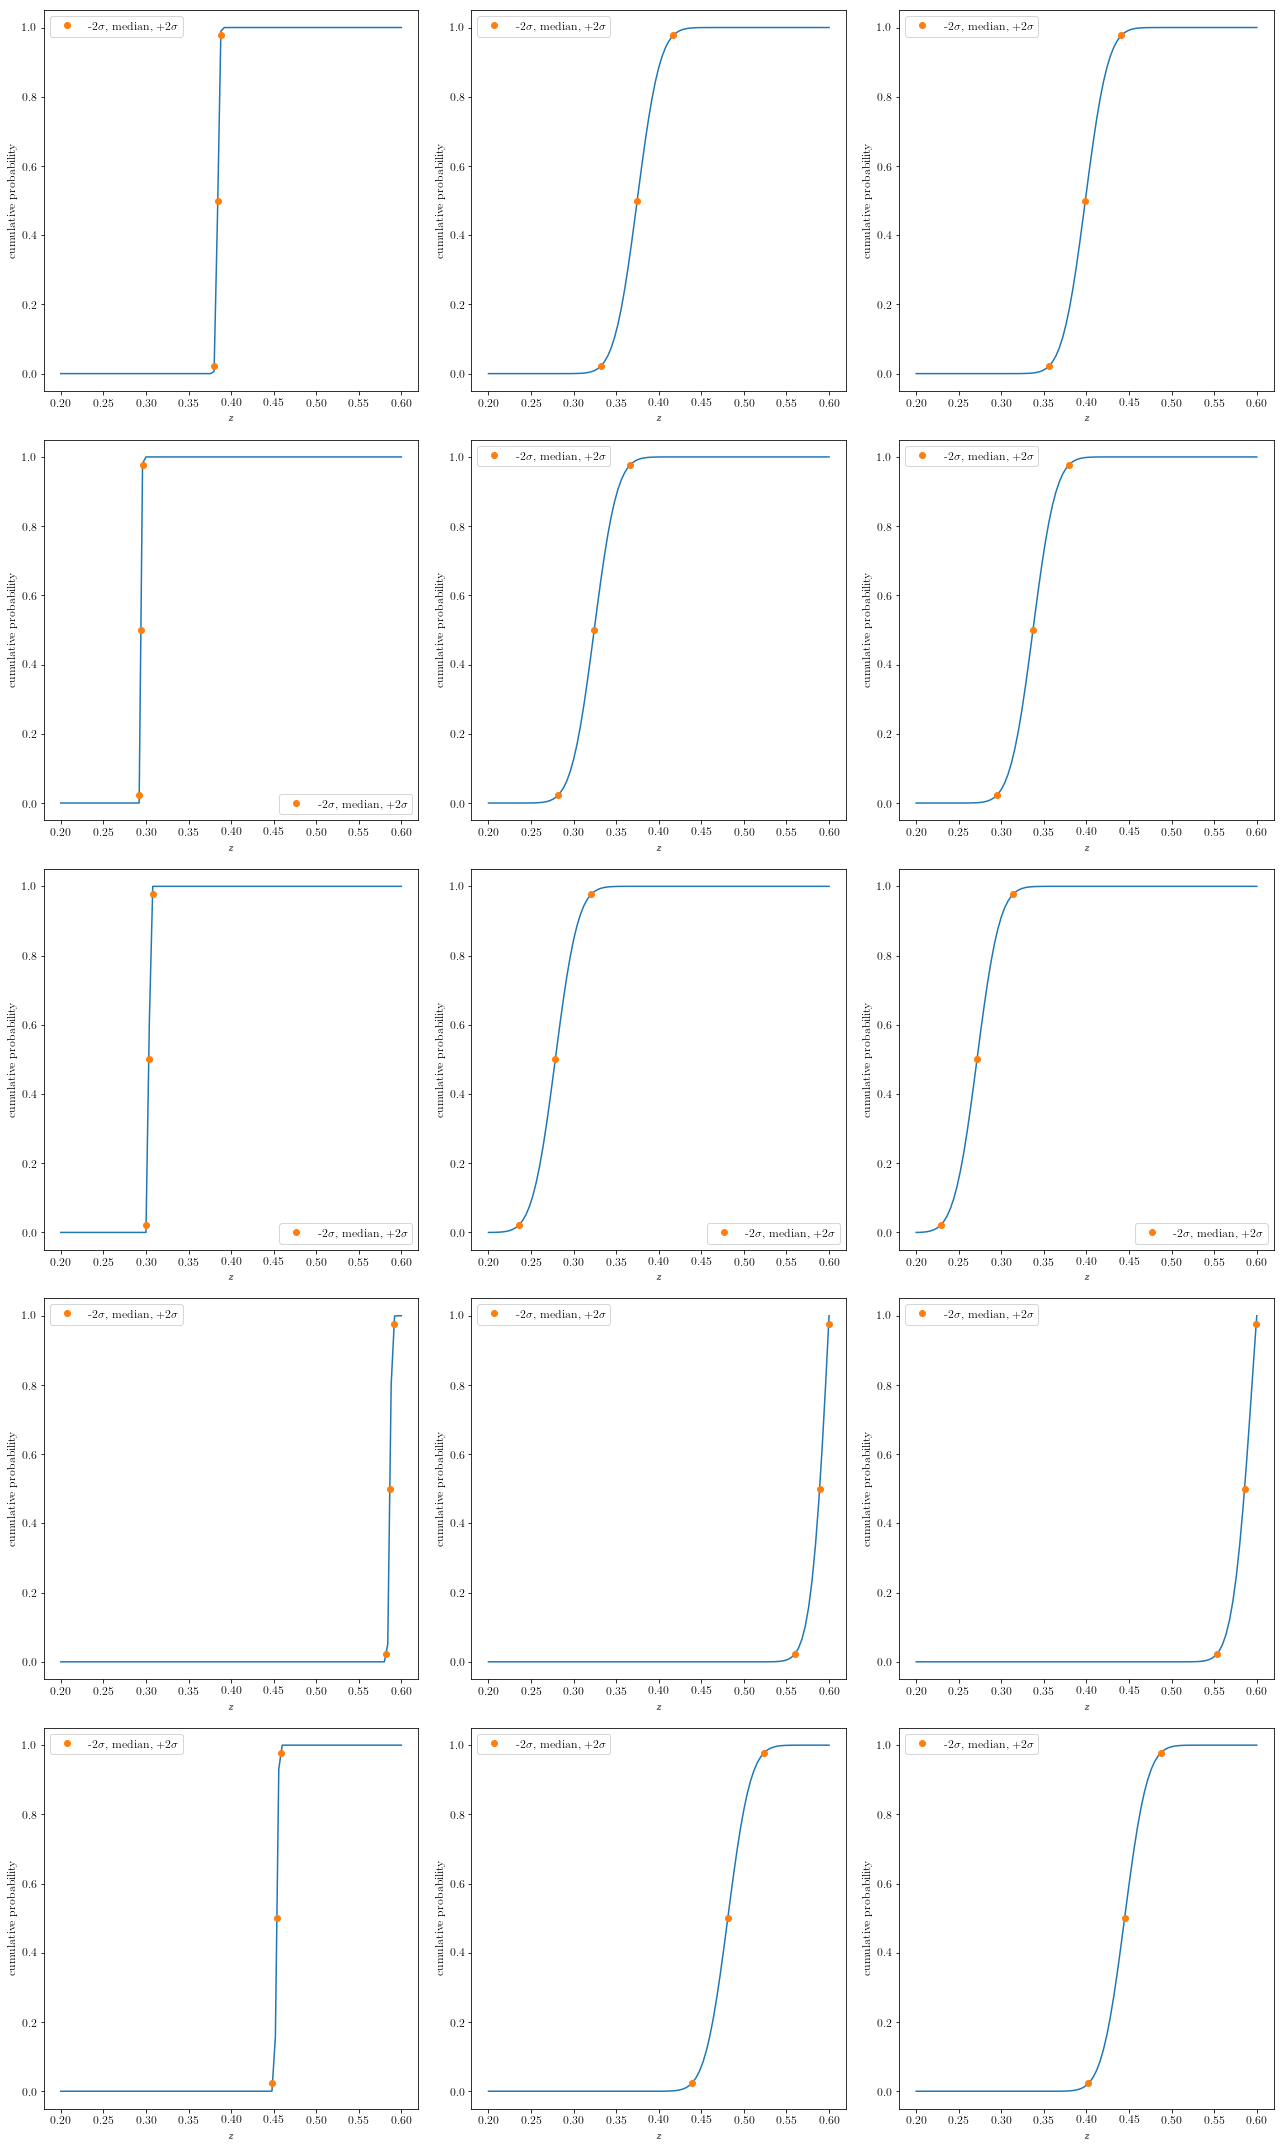

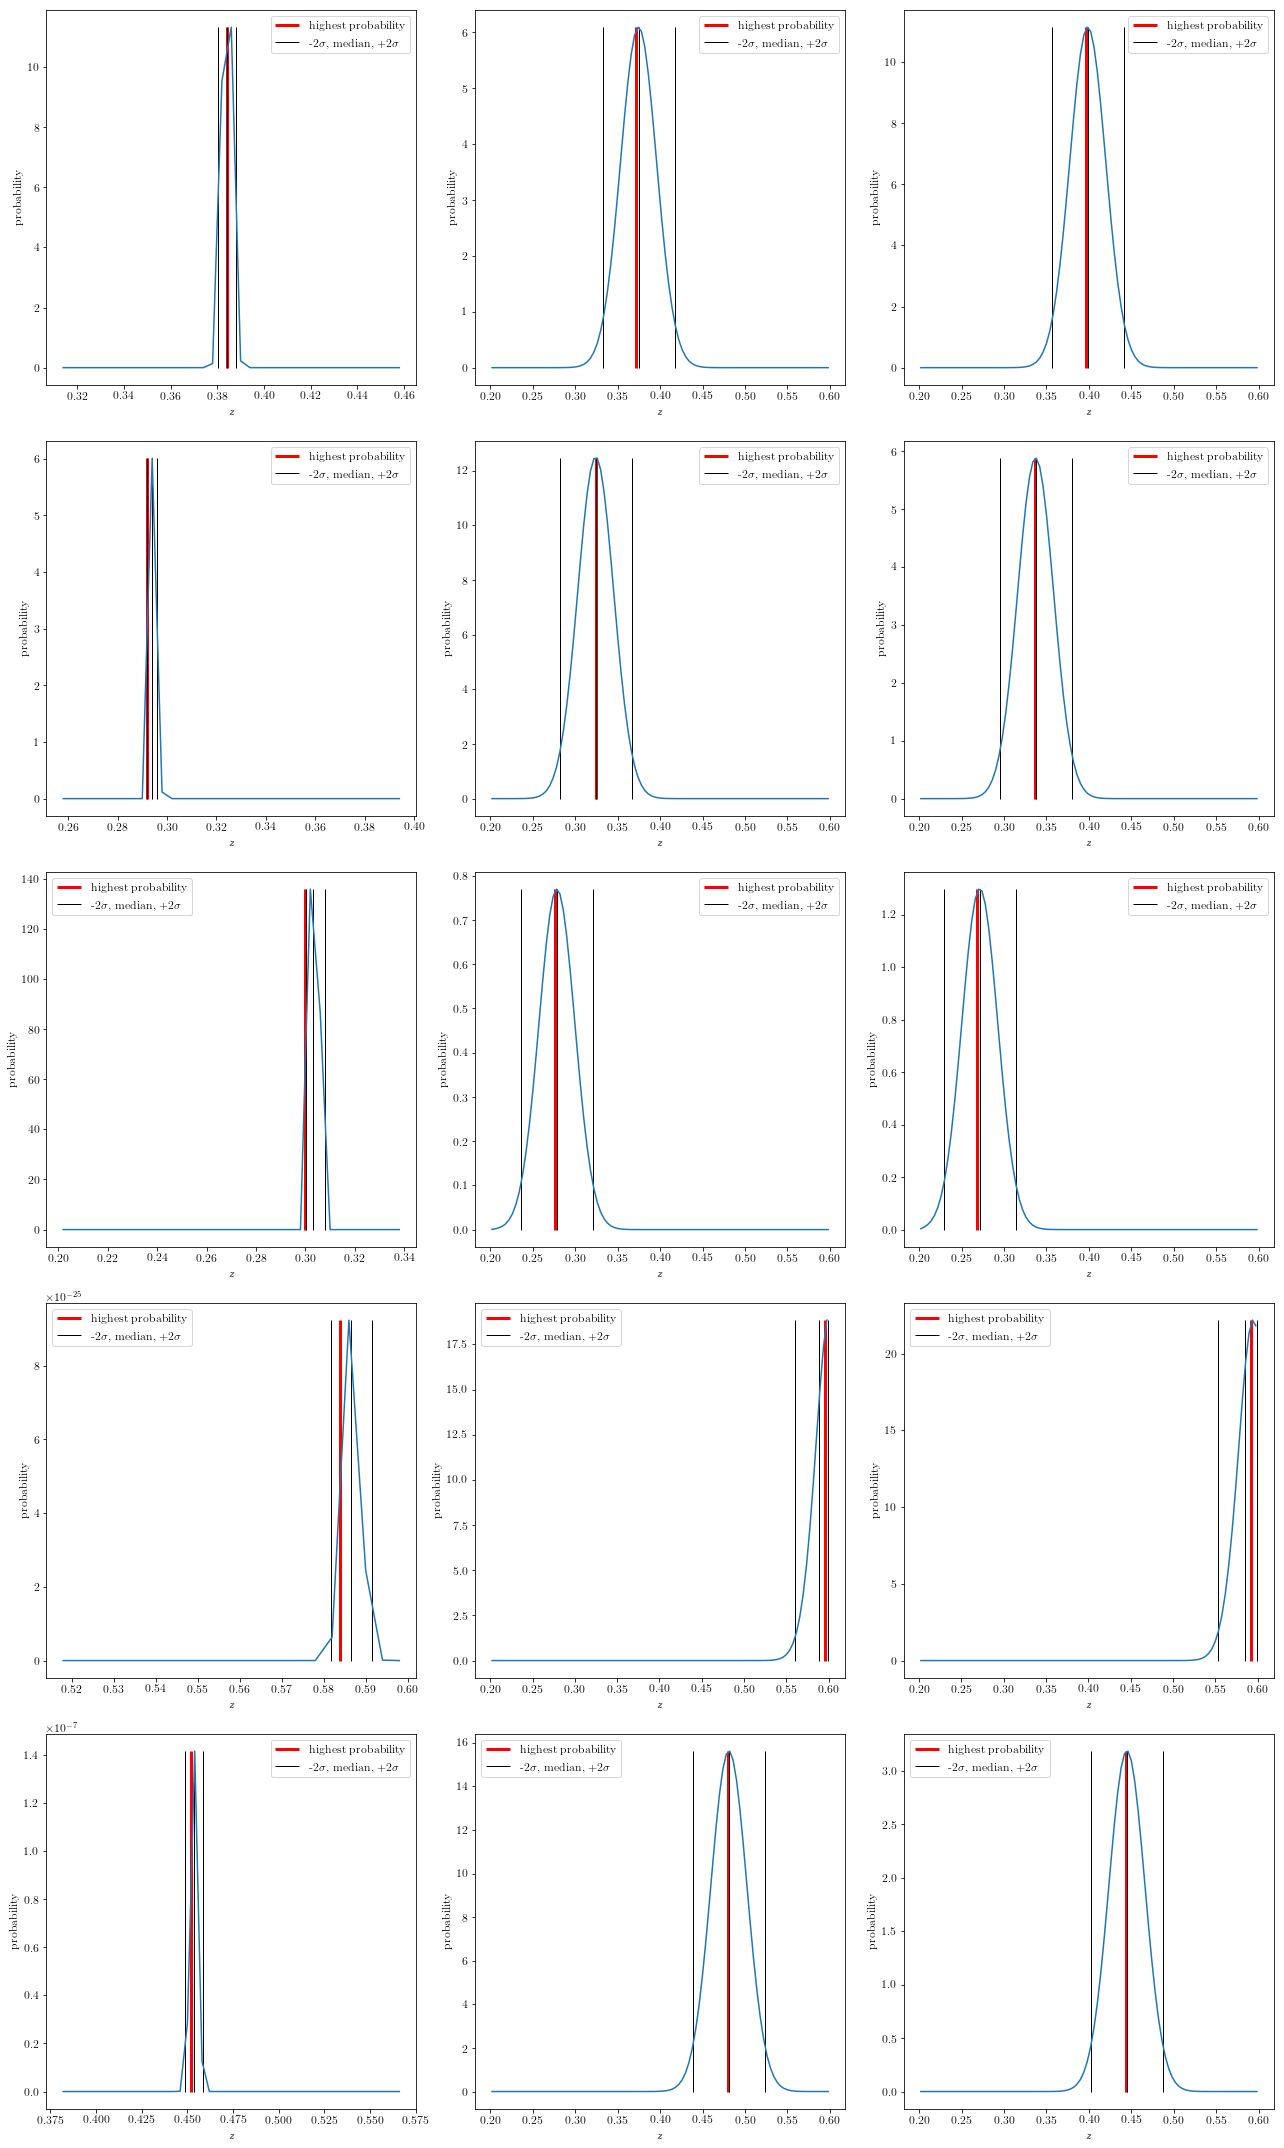

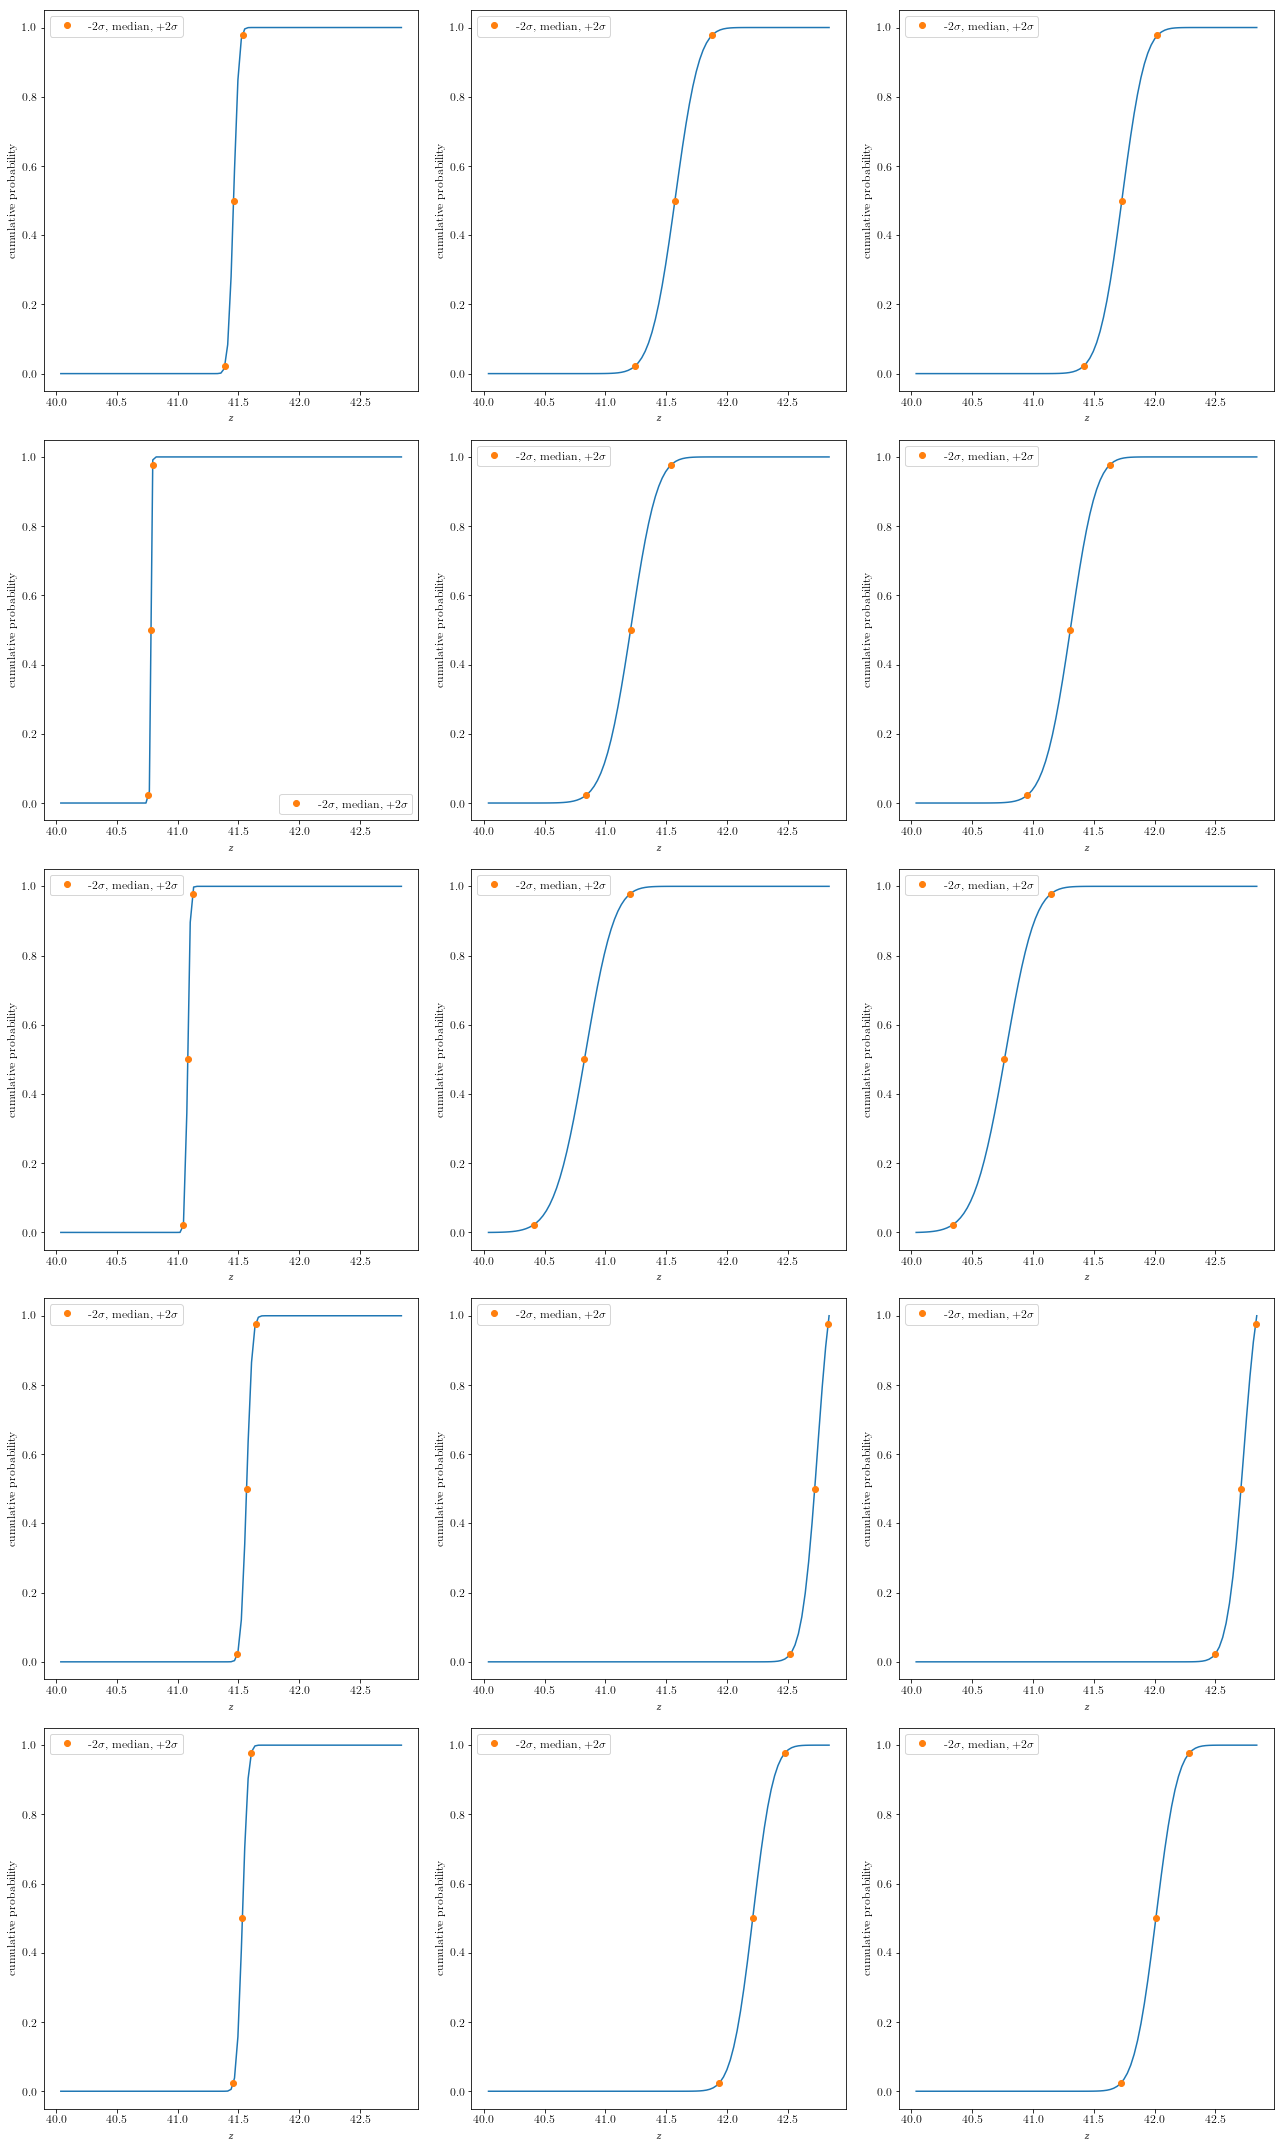

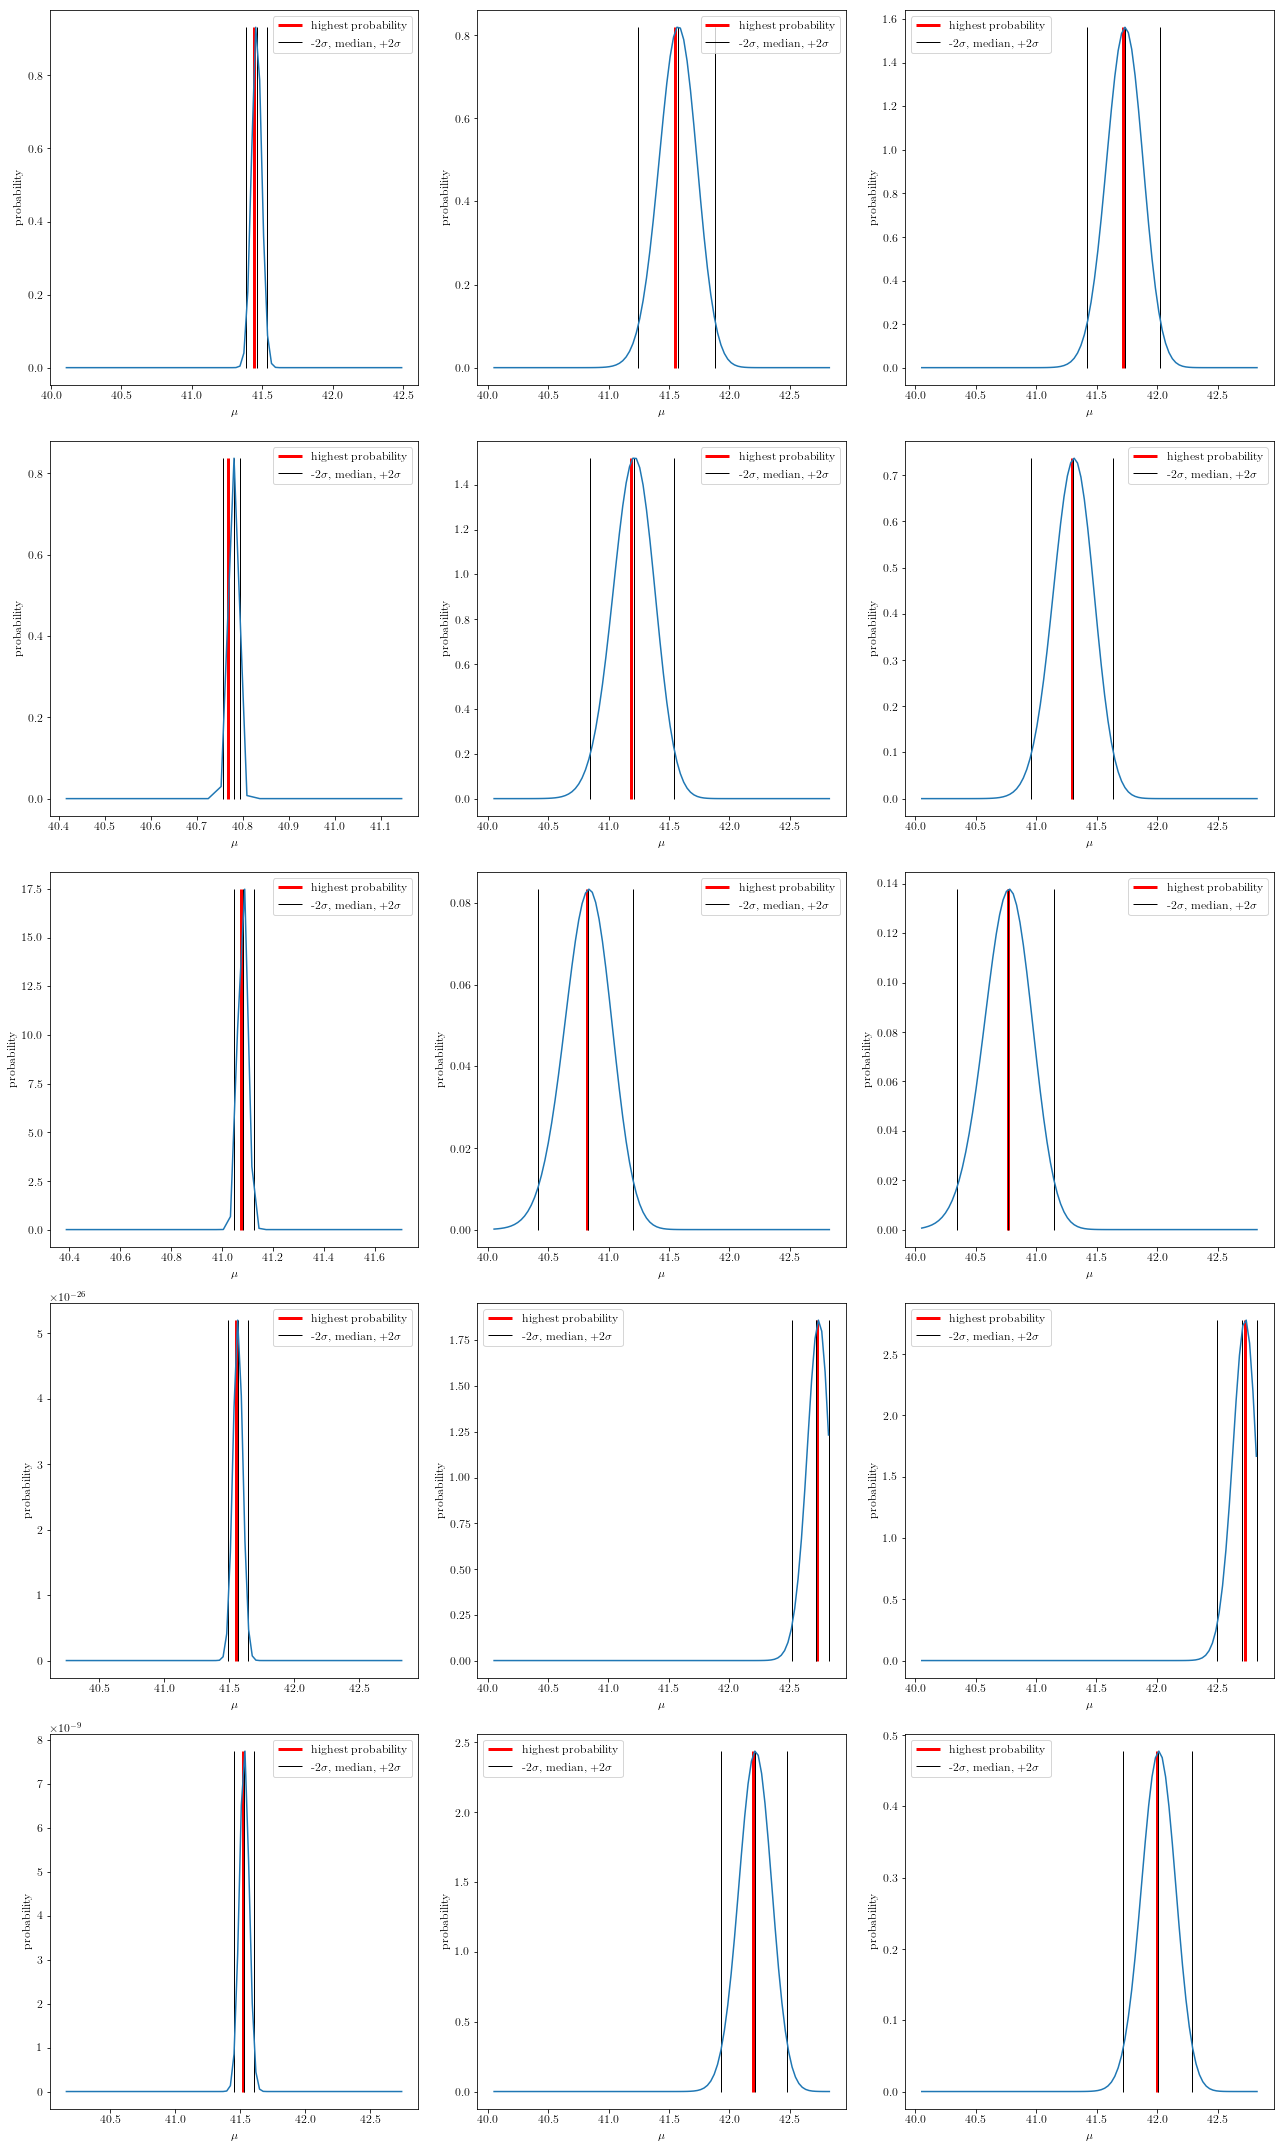

In [160]:
p = 0
fig = plt.figure(figsize=(n_types * 6, 5 * 6))
for sn in range(5):
    for tn in range(n_types):
        p += 1
        zm = lninterimposteriors[sn, tn, :, :]
        
        z_prob  = np.dot(np.exp(zm), mu_difs[:])
        
        xy[0][sn][tn] = z_bins[np.argmax(z_prob)]
        
        z_prob    = np.dot(np.exp(zm), mu_difs[:])
        tot_prob = np.sum(z_prob)
        cum_prob = np.array([])
        for i in range(len(z_bins)):
            cum_prob = np.append(cum_prob, np.sum(z_prob[:i])/tot_prob)
        zspline = interp1d(cum_prob, z_bins)
        zlow,zmed,zhigh = zspline(two_sigma_percentiles)
        
        plt.subplot(5, n_types, p)
        plt.plot(z_bins, cum_prob)
        plt.plot([zlow,zmed,zhigh],two_sigma_percentiles,'o', label=r'-2$\sigma$, median, +2$\sigma$')
        plt.legend()
        plt.xlabel(r'$z$')
        plt.ylabel('cumulative probability')
fig.tight_layout()
plt.savefig('plots/redshift_cumulative_probability.png')

p = 0
fig = plt.figure(figsize=(n_types * 6, 5 * 6))
for sn in range(5):
    for tn in range(n_types):
        p += 1
        
        zm = lninterimposteriors[sn, tn, :, :]
        
        z_prob  = np.dot(np.exp(zm), mu_difs[:])
        
        xy[0][sn][tn] = z_bins[np.argmax(z_prob)]
        
        z_prob    = np.dot(np.exp(zm), mu_difs[:])
        tot_prob = np.sum(z_prob)
        cum_prob = np.array([])
        
        for i in range(len(z_bins)):
            cum_prob = np.append(cum_prob, np.sum(z_prob[:i])/tot_prob)
        zspline = interp1d(cum_prob, z_bins)
        zlow,zmed,zhigh = zspline(two_sigma_percentiles)
        
        plt.subplot(5, n_types, p)
        plt.plot(z_mids[z_prob>3*epsilon], z_prob[z_prob>3*epsilon])
        plt.vlines(xy[0][sn][tn], ymin=min(z_prob), ymax=max(z_prob), color='r', lw=3, label='highest probability')
        plt.vlines([zlow,zmed,zhigh], ymin=min(z_prob), ymax=max(z_prob), color='k', lw=1, label=r'-2$\sigma$, median, +2$\sigma$')
        plt.legend()
        plt.xlabel(r'$z$')
        plt.ylabel('probability')
fig.tight_layout()
plt.savefig('plots/redshift_probability.png')

p = 0
fig = plt.figure(figsize=(n_types * 6, 5 * 6))
for sn in range(5):
    for tn in range(n_types):
        p += 1
        
        hm = lninterimposteriors[sn, tn, :, :].T
        
        mu_prob = np.dot(np.exp(hm), z_difs)
        
        xy[1][sn][tn] = mu_bins[np.argmax(mu_prob)]
        
        mu_prob  = np.dot(np.exp(hm),z_difs)
        tot_prob = np.sum(mu_prob)
        cum_prob = np.array([])
        for i in range(len(mu_bins)):
            cum_prob = np.append(cum_prob, np.sum(mu_prob[:i])/tot_prob)
        muspline = interp1d(cum_prob, mu_bins)
        mulow,mumed,muhigh = muspline(two_sigma_percentiles)
        
        plt.subplot(5, n_types, p)
        plt.plot(mu_bins, cum_prob)
        plt.plot([mulow,mumed,muhigh],two_sigma_percentiles,'o', label=r'-2$\sigma$, median, +2$\sigma$')
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel('cumulative probability')
fig.tight_layout()
plt.savefig('plots/distancemod_cumulative_probability.png')

p = 0
fig = plt.figure(figsize=(n_types * 6, 5 * 6))
for sn in range(5):
    for tn in range(n_types):
        p += 1
        
        hm = lninterimposteriors[sn, tn, :, :].T
        
        mu_prob = np.dot(np.exp(hm), z_difs)
        
        xy[1][sn][tn] = mu_bins[np.argmax(mu_prob)]
        
        mu_prob  = np.dot(np.exp(hm),z_difs)
        tot_prob = np.sum(mu_prob)
        cum_prob = np.array([])
        for i in range(len(mu_bins)):
            cum_prob = np.append(cum_prob, np.sum(mu_prob[:i])/tot_prob)
        muspline = interp1d(cum_prob, mu_bins)
        mulow,mumed,muhigh = muspline(two_sigma_percentiles)
        
        plt.subplot(5, n_types, p)
        plt.plot(mu_mids[mu_prob>3*epsilon], mu_prob[mu_prob>3*epsilon])
        plt.vlines(xy[1][sn][tn], ymin=min(mu_prob), ymax=max(mu_prob), color='r', lw=3, label='highest probability')
        plt.vlines([mulow,mumed,muhigh], ymin=min(mu_prob), ymax=max(mu_prob), color='k', lw=1, label=r'-2$\sigma$, median, +2$\sigma$')
        plt.legend()
        plt.xlabel(r'$\mu$')
        plt.ylabel('probability')
fig.tight_layout()
plt.savefig('plots/distancemod_probability.png')

## Introducing the log-interim posteriors and interim hyperparameters

`scippr` requires inputs in the form of catalogs $\{\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{f}_{n}, \underline{\xi}, \vec{\psi}, \vec{\zeta})]\}_{N}$ of interim log-posteriors expressed as `3D` arrays constituting probabilities over $t_{n}$, $z_{n}$, and $\mu_{n}$, enabling rapid computation of the log-posterior $\ln[p(\underline{\phi}, \vec{\Omega} | \{\underline{\ell}_{n}, \vec{f}_{n}\}_{N})$ over the hyperparameters $\underline{\phi}$ and $\vec{\Omega}$ of scientific interest.  

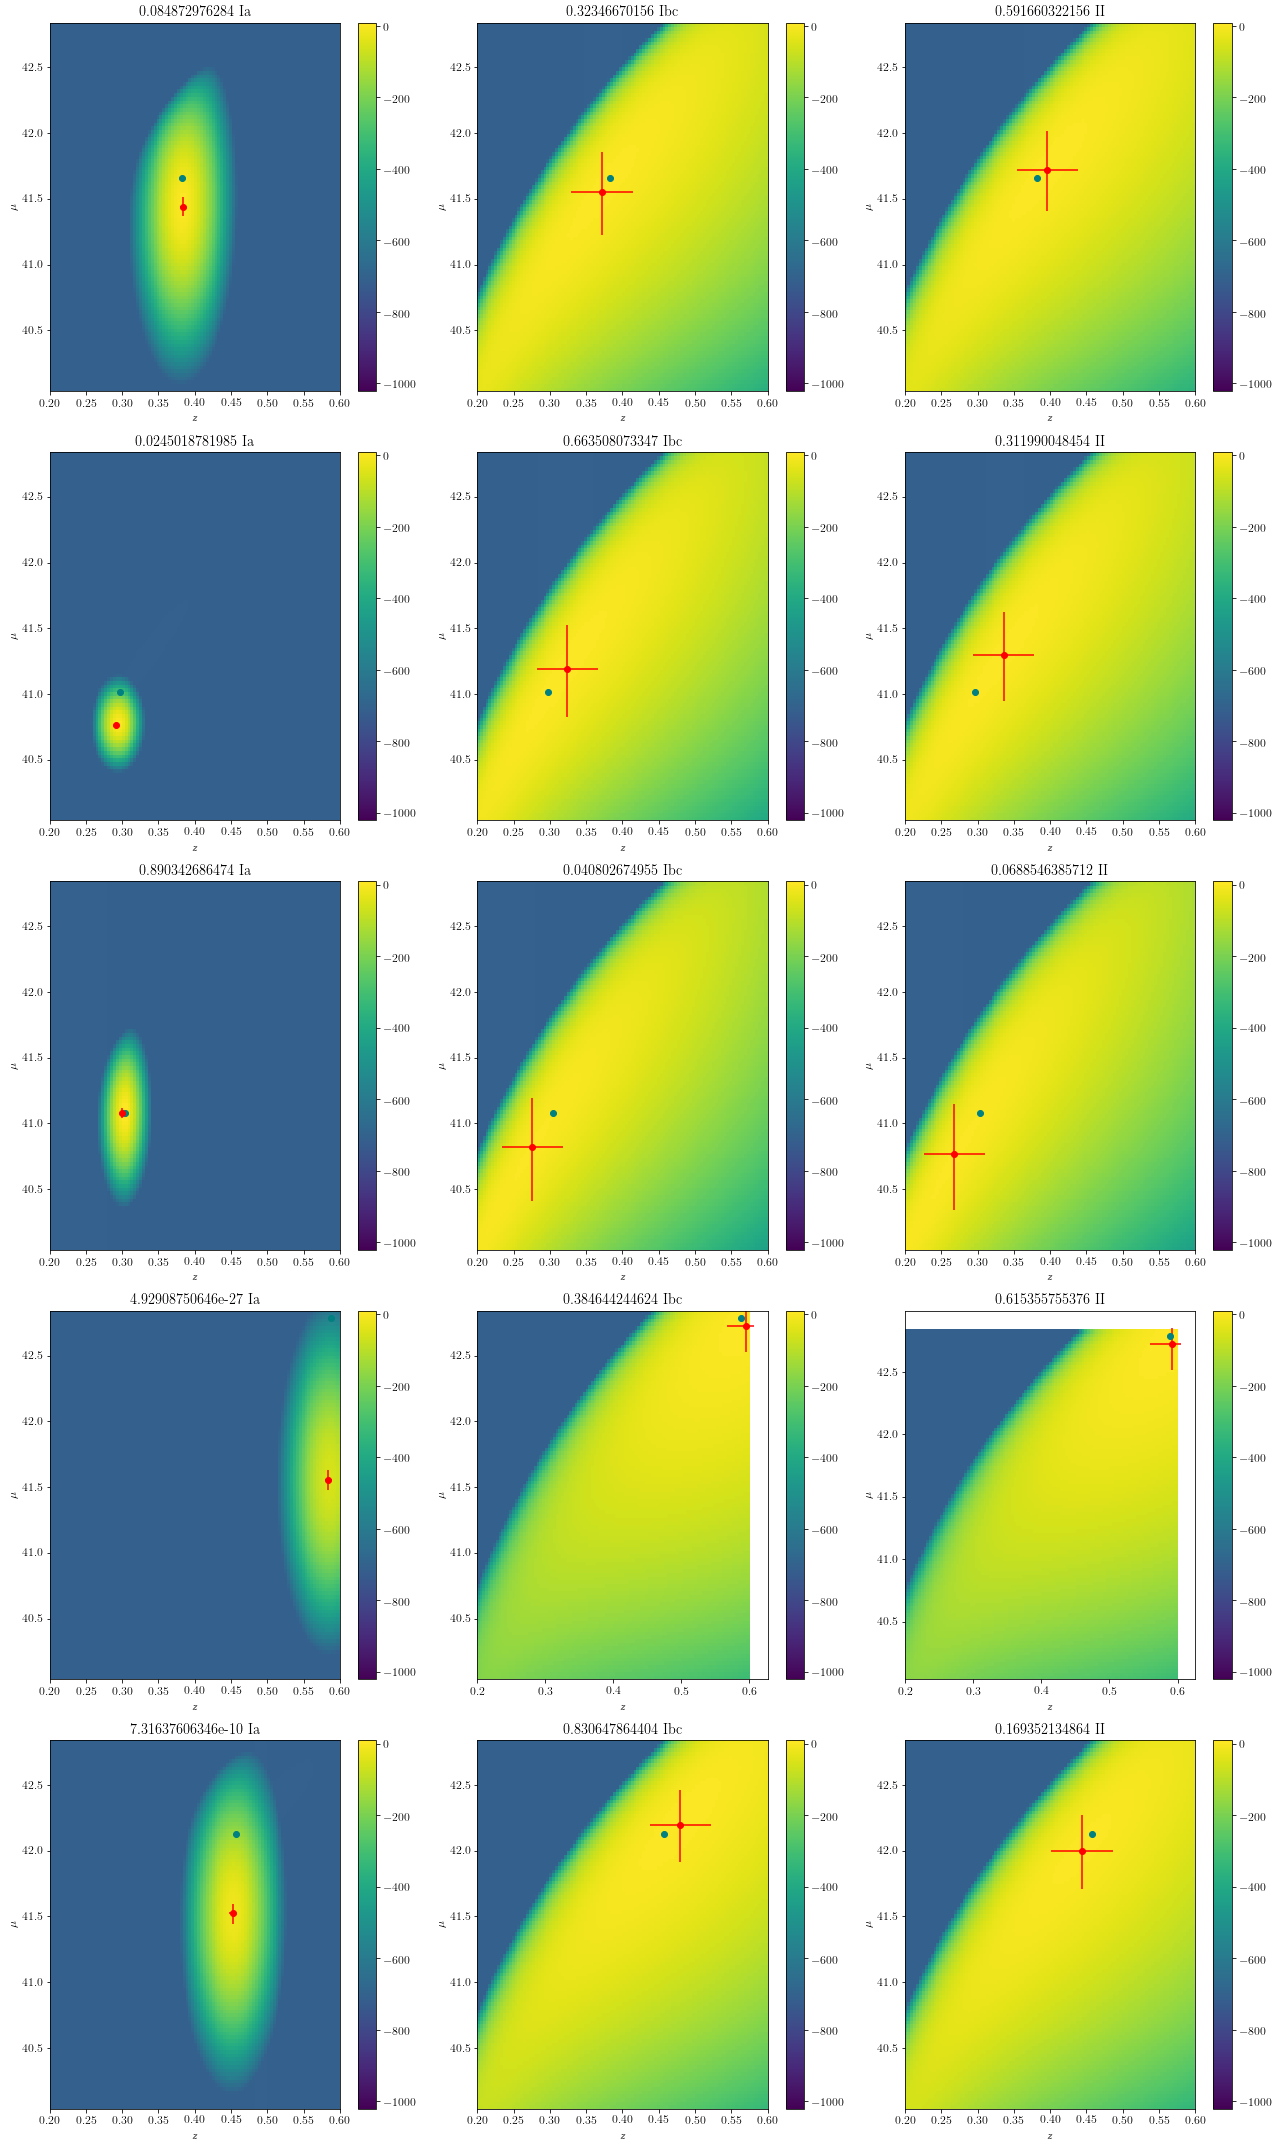

In [158]:
# (n_SNe, n_types, n_zs, n_mus) = np.shape(lninterimposteriors)
# n_zs += 1
# n_mus += 1

fig = plt.figure(figsize=(n_types * 6, 5 * 6))
p = 0
for s in range(5):
    type_dist = np.sum(np.sum(np.exp(lninterimposteriors[s]) * mu_difs[np.newaxis, np.newaxis, :] * z_difs[np.newaxis, :, np.newaxis], axis=2), axis=1)
    for t in range(n_types):
        p += 1
        plt.subplot(5, n_types, p)
        plt.pcolormesh(z_bins, mu_bins, lninterimposteriors[s][t].T, cmap='viridis', vmin = pmin, vmax = pmax)
        plt.errorbar(xy[0][s][t], xy[1][s][t], xerr=np.array([[zerr_lo[s][t]], [zerr_hi[s][t]]]), yerr=np.array([[muerr_lo[s][t]], [muerr_hi[s][t]]]), marker='o', color='r', linestyle='None')
        plt.plot(true_zs[s], true_mus[s], marker='o', color='teal', linestyle='None')
        plt.colorbar()
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.title(str(type_dist[t])+' '+types[t])
        #plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
fig.tight_layout()
plt.savefig('plots/ln_interim_posteriors.png')

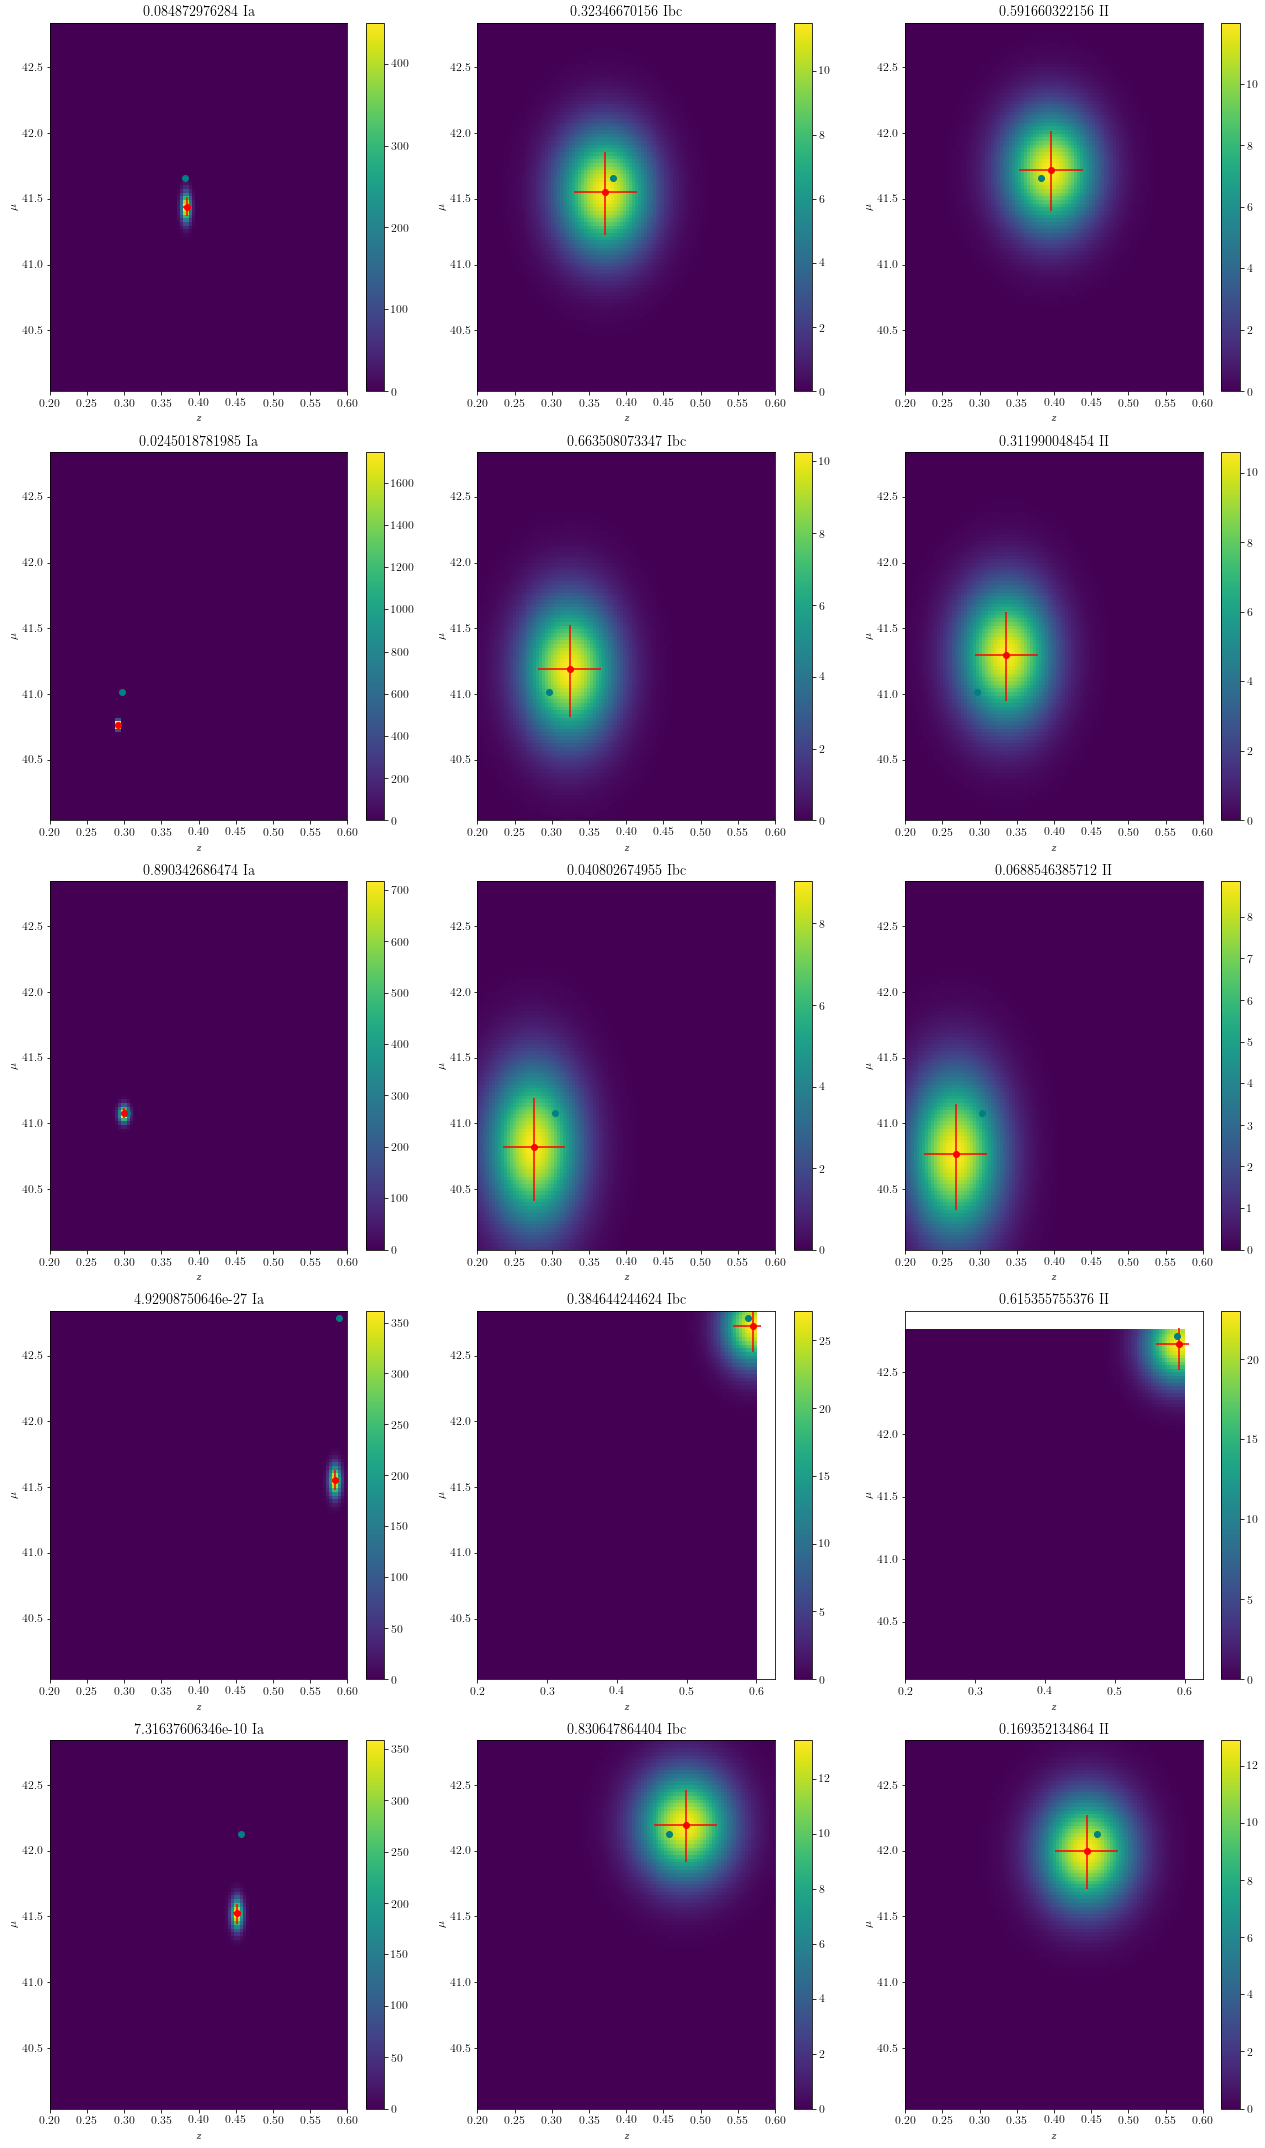

In [177]:
fig = plt.figure(figsize=(n_types * 6, 5 * 6))
p = 0
for s in range(5):
    type_dist = np.sum(np.sum(np.exp(lninterimposteriors[s]) * mu_difs[np.newaxis, np.newaxis, :] * z_difs[np.newaxis, :, np.newaxis], axis=2), axis=1)
    for t in range(n_types):
        p += 1
        plt.subplot(5, n_types, p)
        covar = np.array([max(zerr_lo[s][t],zerr_hi[s][t]), max(muerr_lo[s][t],muerr_hi[s][t])]) ** 2
        new_posterior = sps.multivariate_normal(mean = np.array([xy[0][s][t], xy[1][s][t]]), cov = covar * np.eye(2))
        new_posterior_grid = new_posterior.pdf(z_mu_grid.reshape(((n_zs)*(n_mus), 2))).reshape((n_zs, n_mus))
        plt.pcolormesh(z_bins, mu_bins, new_posterior_grid.T, cmap='viridis') #, vmin = pmin, vmax = pmax)
        plt.errorbar(xy[0][s][t], xy[1][s][t], xerr=np.array([[zerr_lo[s][t]], [zerr_hi[s][t]]]), yerr=np.array([[muerr_lo[s][t]], [muerr_hi[s][t]]]), marker='o', color='r', linestyle='None')
        plt.plot(true_zs[s], true_mus[s], marker='o', color='teal', linestyle='None')
        plt.colorbar()
        plt.xlabel(r'$z$')
        plt.ylabel(r'$\mu$')
        plt.title(str(type_dist[t])+' '+types[t])
        #plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
fig.tight_layout()
plt.savefig('plots/point_ln_interim_posteriors.png')

The interim posteriors must always come with the interim prior $p(t, z, \mu | \underline{\xi})$ used to produce them.  This includes the selection function!

('type_dist', array([ 0.33333333,  0.33333333,  0.33333333]))


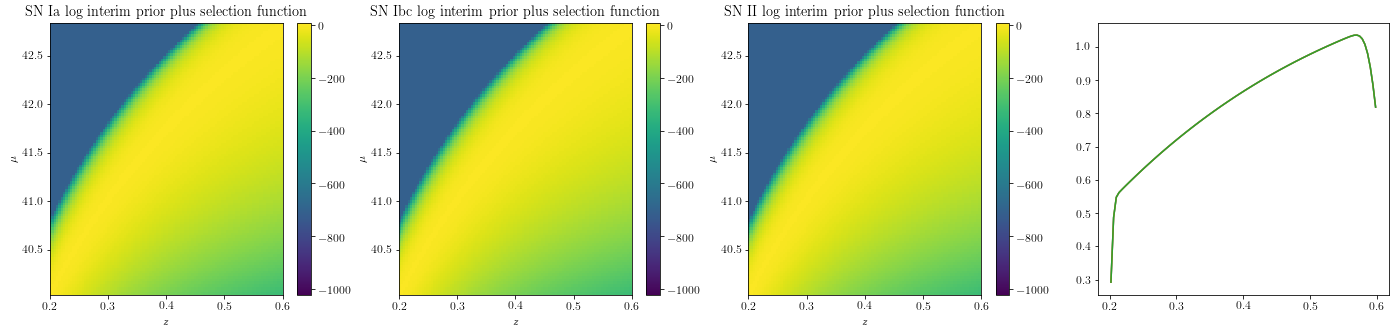

In [161]:
interim_ln_prior = sim_info['ln prior info']
print('type_dist', np.sum(np.sum(np.exp(interim_ln_prior) * mu_difs[np.newaxis, np.newaxis, :] * z_difs[np.newaxis, :, np.newaxis], axis=2), axis=1))
zds = np.sum(np.exp(interim_ln_prior) * mu_difs[np.newaxis, np.newaxis, :], axis=-1)
# assert np.isclose(np.sum(np.exp(interim_ln_prior) * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

fig = plt.figure(figsize=((n_types+1) * 6, 5))
for t in range(n_types):
    plt.subplot(1, n_types+1, t+1)
    plt.pcolormesh(z_bins, mu_bins, interim_ln_prior[t].T, cmap='viridis', vmin = pmin, vmax = pmax)
    plt.title('SN '+types[t]+' log interim prior plus selection function')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$\mu$')
    plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
    plt.colorbar()
plt.subplot(1, n_types+1, 4)
for t in range(n_types):
    plt.plot(z_mids, zds[t])
plt.savefig('plots/full_prior_info.png')

The interim posteriors must also always come with the selection function $p(t, z, \mu | \vec{\psi}, \vec{\zeta})$, which is another sort of interim prior in some sense.

In [ ]:
# ln_selection_function = sim_info['ln selection function']
# # assert np.isclose(np.sum(np.exp(ln_selection_function) * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)

# fig = plt.figure(figsize=(n_types*len(colors), len(colors)))
# for t in range(n_types):
#     plt.subplot(1, n_types, t+1)
#     plt.pcolormesh(z_mids, mu_mids, ln_selection_function[t].T, cmap='viridis')#, vmin = 0., vmax = 3.)
#     plt.title('SN '+types[t]+' log selection function distribution')
#     plt.xlabel(r'$z$')
#     plt.ylabel(r'$\mu$')
#     plt.axis([z_bins[0], z_bins[-1], mu_bins[0], mu_bins[-1]])
#     plt.colorbar()
# plt.savefig('plots/full_selection_function.png')

## Choosing the log-hyperprior probability distribution

As in any Bayesian inference, we must choose a hyperprior distribution over the hyperparameters $\vec{\theta}$ and $\underline{\phi}$ that we wish to estimate.  At this stage we will only attempt to infer $\vec{\theta}=(H_{0}, \Omega_{m0})$.  When we evaluate the log-hyperprior probability $\ln[p(\vec{\theta}, \underline{\phi})]$, we will then be evaluating the log-probability of the hyperprior distribution at the given values of the hyperparameters $\vec{\theta}$ and $\underline{\phi}$.  Thus, the log-hyperprior probability is a scalar as expected.

In [ ]:
def lnprior(hyperparameters):
    cosmo_hyperparameters = hyperparameters#['theta']
#     dist_hyperparameters = hyperparameters['phi']
    if (cosmo_hyperparameters[0] > -2.5) & (cosmo_hyperparameters[0] < 0.5) & (cosmo_hyperparameters[0] > -1.5) & (cosmo_hyperparameters[0] < 1.5):
        cosmo_prior_prob = prior_cosmo_dist.logpdf(cosmo_hyperparameters)
#     dist_prior_prob = prior_n_of_z.logpdf(dist_hyperparameters.flatten())
    else:
        cosmo_prior_prob = -np.nan
    return cosmo_prior_prob # + dist_prior_prob

We will make the assumption that $H_{0}$ and $\Omega_{m0}$ are independent, i.e. $p(\vec{\theta}) = p(H_{0})\ p(\Omega_{m0})$.

In [ ]:
class indie_dist(object):
    def __init__(self, in_dists):
        self.dists = in_dists
        self.n_dists = len(self.dists)
    def rvs(self, n_samps = 1):
        samps = []
        for d in range(self.n_dists):
            samps.append(self.dists[d].rvs(n_samps))
        return np.array(samps).T
    def logpdf(self, locs):
        n_items = len(locs)
        lnprob = 0
        for d in range(self.n_dists):
            lnprob += self.dists[d].logpdf(locs[d])
        return lnprob

We make the choice to set hyperprior distributions to be Gaussian for $H_{0}$ and truncated normal for $\Omega_{m0}$ (so it must be a fraction) with means equal to the WMAP values for these parameters and standard deviations equal to the $3\sigma$ errors on those measurements.

In [ ]:
# n_sigmas = 2.

# # WMAP, with 10 * errors so we can see what's going on in crappy plots
# wmap_H0 = 70.0
# delta_H0 = 2.2 * n_sigmas
# [H0_mean, H0_std] = [wmap_H0, delta_H0]
# min_H0, max_H0 = 50., 90.
# H0_range = max_H0 - min_H0
# H0_low, H0_high = (min_H0 - H0_mean) / H0_std, (max_H0 - H0_mean) / H0_std
# H0_dist = sps.norm(H0_mean, H0_std)#sps.truncnorm(H0_low, H0_high, loc = H0_mean, scale = H0_std)

# wmap_Om0 = 1. - 0.721
# delta_Om0 = 0.025 * n_sigmas
# [Om0_mean, Om0_std] = [wmap_Om0, delta_Om0]
# min_Om0, max_Om0 = 0., 1.
# Om0_low, Om0_high = (min_Om0 - Om0_mean) / Om0_std, (max_Om0 - Om0_mean) / Om0_std
# Om0_dist = sps.norm(Om0_mean, Om0_std)#sps.truncnorm(Om0_low, Om0_high, loc = Om0_mean, scale = Om0_std)

# prior_cosmo_hyperparams = np.array([H0_dist.rvs(), Om0_dist.rvs()])
# cosmo_param_names = [r'$H_{0}$', r'$\Omega_{m0}$']
# n_cosmo_hyperparams = len(prior_cosmo_hyperparams)
# prior_cosmo_dist = indie_dist([H0_dist, Om0_dist])
# prior_cosmo = cosmology.FlatLambdaCDM(H0=prior_cosmo_hyperparams[0], Om0=prior_cosmo_hyperparams[1])

# def param_check(params):
#     if params[0] > min_H0 and params[0] < max_H0 and params[1] > min_Om0 and params[1] < max_Om0:
#         return True
#     else:
#         return False

# # # prior on phi is gaussian about flat in log space
# # prior_mean = np.ones((n_types, n_zs)) / n_types
# # prior_mean /= np.sum(prior_mean * z_difs[np.newaxis, :])
# # assert np.isclose(np.sum(prior_mean * z_difs[np.newaxis, :]), 1.)
# # prior_mean = safe_log(prior_mean.flatten())
# # prior_sigmas = np.array([0.5, 1., 0.25])
# # prior_covariance = la.block_diag(prior_sigmas[0] * np.eye(n_zs), prior_sigmas[1] * np.eye(n_zs), prior_sigmas[2] * np.eye(n_zs))
# # # prior_n_of_z_hyperparams = [prior_mean, prior_sigmas]
# # prior_n_of_z_dist = sps.multivariate_normal(mean = prior_mean, cov = prior_covariance)

# H0_grid = 50. + 50. * np.arange(0., 1., 0.01)
# Om0_grid = np.arange(0., 1., 0.01)
# prior_space = np.zeros((100, 100))
# for i in range(100):
#     for j in range(100):
#         prior_space[i][j] = lnprior(np.array([H0_grid[i], Om0_grid[j]]))
# plt.pcolormesh(H0_grid, Om0_grid, prior_space.T, cmap='viridis')#, vmin = 0., vmax = 3.)
# plt.colorbar()
# plt.xlabel(r'$H_{0}$')
# plt.ylabel(r'$\Omega_{m0}$')
# plt.axis([H0_grid[0], H0_grid[-1], Om0_grid[0], Om0_grid[-1]])
# plt.savefig('plots/prior_dist.png')

# WMAP, with 10 * errors so we can see what's going on in crappy plots
prior_w0 = -1.0
delta_w0 = 0.25
[w0_mean, w0_std] = [prior_w0, delta_w0]
min_w0, max_w0 = -1.5, -0.5
w0_range = max_w0 - min_w0
w0_low, w0_high = (min_w0 - w0_mean) / w0_std, (max_w0 - w0_mean) / w0_std
w0_dist = sps.norm(w0_mean, w0_std)#sps.truncnorm(H0_low, H0_high, loc = H0_mean, scale = H0_std)

prior_wa = 0.0
delta_wa = 0.25
[wa_mean, wa_std] = [prior_wa, delta_wa]
min_wa, max_wa = -0.5, 0.5
wa_range = max_wa - min_wa
wa_low, wa_high = (min_wa - wa_mean) / wa_std, (max_wa - wa_mean) / wa_std
wa_dist = sps.norm(wa_mean, wa_std)#sps.truncnorm(Om0_low, Om0_high, loc = Om0_mean, scale = Om0_std)

prior_cosmo_hyperparams = np.array([w0_dist.rvs(), wa_dist.rvs()])
cosmo_param_names = [r'$w_{0}$', r'$w_{a}$']
n_cosmo_hyperparams = len(prior_cosmo_hyperparams)
prior_cosmo_dist = indie_dist([w0_dist, wa_dist])

# Planck 2015 results XIV. Dark energy and modified gravity - Figure 3
prior_H0 = 67.9
prior_Ode0 = 0.693
prior_Om0 = 1. - prior_Ode0
prior_cosmo = cosmology.w0waCDM(prior_H0, prior_Om0, prior_Ode0, w0=prior_cosmo_hyperparams[0], wa=prior_cosmo_hyperparams[1])

def param_check(params):
#     if params[0] > min_w0 and params[0] < max_w0 and params[1] > min_wa and params[1] < max_wa:
#         return True
#     else:
#         return False
    return True

# # prior on phi is gaussian about flat in log space
# prior_mean = np.ones((n_types, n_zs)) / n_types
# prior_mean /= np.sum(prior_mean * z_difs[np.newaxis, :])
# assert np.isclose(np.sum(prior_mean * z_difs[np.newaxis, :]), 1.)
# prior_mean = safe_log(prior_mean.flatten())
# prior_sigmas = np.array([0.5, 1., 0.25])
# prior_covariance = la.block_diag(prior_sigmas[0] * np.eye(n_zs), prior_sigmas[1] * np.eye(n_zs), prior_sigmas[2] * np.eye(n_zs))
# # prior_n_of_z_hyperparams = [prior_mean, prior_sigmas]
# prior_n_of_z_dist = sps.multivariate_normal(mean = prior_mean, cov = prior_covariance)

w0_grid = np.linspace(min_w0, max_w0, 100)
wa_grid = np.linspace(min_wa, max_wa, 100)
prior_space = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        prior_space[i][j] = lnprior(np.array([w0_grid[i], wa_grid[j]]))
plt.figure(figsize=(6, 5))
plt.pcolormesh(w0_grid, wa_grid, prior_space.T, cmap='viridis')#, vmin = 0., vmax = 3.)
plt.colorbar()
plt.xlabel(r'$w_{0}$')
plt.ylabel(r'$w_{a}$')
plt.axis([w0_grid[0], w0_grid[-1], wa_grid[0], wa_grid[-1]])
plt.savefig('plots/prior_dist.png')

## Calculating the log-hyperlikelihood

The log-hyperlikelihood $\ln[p(t_{n}, z_{n}, \mu_{n} | \vec{\theta}, \underline{\phi})] = \ln[p(t_{n}, z_{n} | \underline{\phi})]+\ln[p(\mu_{n} | z_{n}, \vec{\theta})]$ is the sum of two terms separable in the hyperparameters.  In our parametrization, the first is derived from a constant lookup table that can be neglected for now and the second is a $\delta$ function located at the `cosmo.distmod()` function evaluated at the given redshift where `cosmo` is defined using the cosmological parameters in $\vec{\theta}$.  We will at this stage need to introduce a function mapping redshifts into distance moduli under a given cosmology.  We note that we will be using some particular values of the log-hyperlikelihood repeatedly so will define them as constants.

In [ ]:
# lnselectionfunction = ln_selection_function
# lninterimhyperlikelihood = interim_ln_prior
print np.shape(interim_ln_prior)
flat_hyperlikelihood = np.ones(np.shape(interim_ln_prior))
flat_hyperlikelihood /= np.sum(flat_hyperlikelihood * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
# assert np.isclose(np.sum(flat_hyperlikelihood * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, :, np.newaxis]), 1.)
flat_lnhyperlikelihood = safe_log(flat_hyperlikelihood)#log_epsilon * np.ones(np.shape(interim_ln_prior))

def lnhyperlikelihood(hyperparameters):
#     cosmo_hyperparameters = hyperparameters#['theta']
#     dist_hyperparameters = hyperparameters['phi']
    if param_check(hyperparameters):
#         sample_cosmo = cosmology.FlatLambdaCDM(H0=cosmo_hyperparameters[0], Om0=cosmo_hyperparameters[1])
        sample_cosmo = cosmology.w0waCDM(prior_H0, prior_Om0, prior_Ode0, w0=hyperparameters[0], wa=hyperparameters[1])
        delta = mu_binner(sample_cosmo.distmod(z_mids).value)
        delta /= np.sum(delta * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :])
        assert np.isclose(np.sum(delta * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :]), 1.)
        lnprob = safe_log(delta) # + dist_hyperparameters[:, :, np.newaxis]
    else:
        lnprob = flat_lnhyperlikelihood
    return lnprob

def mu_binner(mus):
    matrix = []
    for mu in mus:
        vector = np.zeros(n_mus)
        ind = bisect.bisect(mu_bins[:-1], mu) - 1
        vector[ind] += 1.
        matrix.append(vector)
    return np.array([matrix] * n_types)

## Constructing the log-posterior probability

The full log-posterior probability takes the following form:
\begin{align}
\ln[p(\vec{\theta}, \underline{\phi} | \{\underline{\ell}_{n}, \vec{m}_{n}\}_{N})] \propto & \ln[p(\vec{\theta}, \underline{\phi})]\\
& +\sum_{n}^{N}\ \ln[\iiint\ \exp[\ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\ell}_{n}, \vec{m}_{n}, \underline{\xi}, \vec{\psi}, \vec{\zeta})] + \ln[p(t_{n}, z_{n}, \mu_{n} | \vec{\theta}, \underline{\phi})]\\
\ \ \ \ \ & - \ln[p(t_{n}, z_{n}, \mu_{n} | \underline{\xi}) - \ln[p(t_{n}, z_{n}, \mu_{n} | \vec{\psi}, \vec{\zeta})]]\ d\mu_{n}\ dz_{n}\ dt_{n}]
\end{align}

In words, that's the sum of the log-prior probability and the sum of the logs of the integrals over the sum of the log-interim posteriors, the log-hyperlikelihood, the negative log-interim hyperlikelihood, and the negative log selection function.

In [ ]:
const_term = reg_vals(lninterimposteriors - interim_ln_prior)#lninterimhyperlikelihood[np.newaxis, :] - lnselectionfunction[np.newaxis, :])
assert(np.all(np.exp(const_term) * z_difs[np.newaxis, :, np.newaxis] * mu_difs[np.newaxis, np.newaxis, :] / n_types) >= 0.)

def lnposterior(hyperparameters):
    new_term = lnhyperlikelihood(hyperparameters)
    in_exp = reg_vals(const_term + new_term[np.newaxis, :])
#     assert np.all(in_exp) <= 0.
    in_log = np.sum(np.sum(np.sum(np.exp(in_exp) * mu_difs[np.newaxis, np.newaxis, np.newaxis, :] * z_difs[np.newaxis, np.newaxis, :, np.newaxis], axis=3), axis=2), axis=1)
    in_sum = safe_log(in_log)
    summed = np.sum(in_sum, axis=0)
#     assert summed <= 0.
    return summed

def lnhyperposterior(hyperparameters):
    lnhyppos = np.nanmax([lnprior(hyperparameters) + lnposterior(hyperparameters), log_epsilon])
    return lnhyppos

# MCMC Sampler

In [ ]:
mcrandstep = 10.**-1.
nthreads = 4
nwalkers = 100
nsteps = 100
ninit = 100
output_chain = True
emcee_chain_output = "data/emcee_chain_testing.dat"
gr_limit = 1.1

In [ ]:
def sample(sampler, ivals, n_samps):
    sampler.reset()
    stuff = sampler.run_mcmc(ivals, n_samps, thin=10)
    mcmc_outputs = {}
    mcmc_outputs['chain'] = sampler.chain
    mcmc_outputs['lnprobability'] = sampler.lnprobability
    mcmc_outputs['acceptance_fraction'] = sampler.acceptance_fraction
#     mcmc_outputs['acor'] = sampler.acor
    return mcmc_outputs

def single_parameter_gr_stat(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    xb = np.mean(chain, axis=1)
    xbb = np.mean(xb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1.) * np.sum((xbb - xb)**2., axis=0)
    var_x = (n - 1.) / n * W + 1. / n * B
    R_hat = np.sqrt(var_x / W)
    return R_hat

def multi_parameter_gr_stat(sample):
    dims = np.shape(sample)
    (n_walkers, n_iterations, n_params) = dims
    n_burn_ins = n_iterations / 2
    chain_ensemble = np.swapaxes(sample, 0, 1)
    chain_ensemble = chain_ensemble[n_burn_ins:, :]
    Rs = np.zeros((n_params))
    for i in range(n_params):
        chains = chain_ensemble[:, :, i].T
        Rs[i] = single_parameter_gr_stat(chains)
    return Rs

def gr_test(sample, threshold=gr_limit):
    gr = multi_parameter_gr_stat(sample)
    print('Gelman-Rubin test statistic = '+str(gr))
    return np.max(gr) > threshold
    
def run_MCMC(ivals):
    sampler = emcee.EnsembleSampler(nwalkers, n_cosmo_hyperparams, lnhyperposterior, threads=nthreads)
    burn_ins = 0
    burning_in = True
    vals = ivals
    full_chain = np.array([[ivals[w]] for w in range(nwalkers)])
    while burning_in:
        print('began sampling '+str(burn_ins))
        burn_in_mcmc_outputs = sample(sampler, vals, ninit)
        print('finished sampling '+str(burn_ins))
        with open('data/mcmc'+str(burn_ins)+'.hkl', 'w') as file_location:
            pickle.dump(burn_in_mcmc_outputs, file_location)
        progress_plotter(burn_ins)
        full_chain = np.concatenate((full_chain, burn_in_mcmc_outputs['chain']), axis=1)
        burning_in = gr_test(full_chain)
        vals = np.array([item[-1] for item in burn_in_mcmc_outputs['chain']])
        burn_ins += 1
    with open('data/burn_chain.hkl', 'w') as file_location:
        pickle.dump(full_chain, file_location)
    mcmc_outputs = sample(sampler, vals, nsteps)
#     full_chain = np.concatenate((full_chain, mcmc_outputs['chain']), axis=1)
    with open('data/final_chain.hkl', 'w') as file_location:
        pickle.dump(mcmc_outputs['chain'], file_location)
    return mcmc_outputs['chain']
        
def progress_plotter(burn_ins):
    with open('data/mcmc'+str(burn_ins)+'.hkl', 'r') as file_location:
        to_plot = pickle.load(file_location)
    fig = plt.figure(figsize=(10, 10))
    sps_prob = fig.add_subplot(2, 2, 1)
    for w in range(nwalkers):
        sps_prob.plot(to_plot['lnprobability'][w], alpha=0.1)
    sps_prob.set_title('lnprobability evolution for samples '+str(burn_ins*ninit)+'-'+str((burn_ins+1)*ninit))
    sps_wa = fig.add_subplot(2, 2, 3)
    for w in range(nwalkers):
        sps_wa.plot(to_plot['chain'][w].T[1], alpha=0.1)
    sps_wa.set_title(r'$w_{a}$ evolution for samples '+str(burn_ins*ninit)+'-'+str((burn_ins+1)*ninit))
    sps_w0 = fig.add_subplot(2, 2, 2)
    for w in range(nwalkers):
        sps_w0.plot(to_plot['chain'][w].T[0], alpha=0.1)
    sps_w0.set_title(r'$w_{0}$ evolution for samples '+str(burn_ins*ninit)+'-'+str((burn_ins+1)*ninit))
    sps_chain = fig.add_subplot(2, 2, 4)
    for w in range(nwalkers):
        sps_chain.plot(to_plot['chain'][w,:,:].T[0], to_plot['chain'][w,:,:].T[1], '.', alpha=0.5)
        sps_chain.plot(to_plot['chain'][w,:,:].T[0], to_plot['chain'][w,:,:].T[1], '-', alpha=0.05)
        #sps_chain.scatter(to_plot['chain'][w].T[0], to_plot['chain'][w].T[1], alpha=0.1)
    sps_chain.scatter(-1.0, 0.0, color='r')
    sps_chain.set_xlim(-2.5, 0.5)
    sps_chain.set_ylim(-1.5, 1.5)
    sps_chain.set_xlabel(cosmo_param_names[0])
    sps_chain.set_ylabel(cosmo_param_names[1])
    fig.savefig('plots/progress_'+str(burn_ins)+'.png')
    fig.show()
    return

In [ ]:
#init_positions = []
#while len(init_positions) < nwalkers:
#    pair = prior_cosmo_dist.rvs()[0]
#    if param_check(pair):
#        init_positions.append(pair)
#init_positions = np.array(init_positions)

init_positions = prior_cosmo_dist.rvs(nwalkers)
init_probs = np.array([lnposterior(ival) for ival in init_positions])
plt.hist(init_probs)

In [ ]:
init_positions = prior_cosmo_dist.rvs(nwalkers)

fig = plt.figure(figsize=(10, 10))
plt.scatter(init_positions.T[0], init_positions.T[1], s=5)
plt.scatter(-1.0, 0.0, color='r')
plt.xlim(-2.5, 0.5)
plt.ylim(-1.5, 1.5)
plt.xlabel(cosmo_param_names[0])
plt.ylabel(cosmo_param_names[1])
fig.savefig('plots/init_positions.png')
fig.show()

In [ ]:
for path in ['data/burn_chain.hkl', 'data/final_chain.hkl']:
    if os.path.exists(path):
        os.remove(path)

pr = cProfile.Profile()
pr.enable()

results = run_MCMC(init_positions)

pr.disable()
s = StringIO.StringIO()
sortby = 'cumtime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()

In [ ]:
with open('data/mcmc0.hkl', 'r') as file_location:
    to_plot = pickle.load(file_location)
print np.shape(to_plot['chain'])
print to_plot['chain'][0,:,:].T[0]

print to_plot['acceptance_fraction']

for w in range(10):
    plt.plot(to_plot['chain'][w,:,:].T[0], to_plot['chain'][w,:,:].T[1], '.', alpha=0.5)
    plt.plot(to_plot['chain'][w,:,:].T[0], to_plot['chain'][w,:,:].T[1], '-', alpha=0.05)
plt.scatter(-1.0, 0.0, color='r')
plt.xlim(-2.5, 0.5)
plt.ylim(-1.5, 1.5)
plt.xlabel(cosmo_param_names[0])
plt.ylabel(cosmo_param_names[1])

# Comparison

In [ ]:
# for w in range(nwalkers):
#     to_plot = results['chain'][w].T
#     plt.scatter(to_plot[0], to_plot[1], alpha=0.01)#1./np.mean(results['probs'][w]))
# plt.scatter(67.9, 1. - 0.693, color='r')
# plt.xlabel(cosmo_param_names[0])
# plt.ylabel(cosmo_param_names[1])
# plt.savefig('bananas.png')

# Comparison

In [ ]:
with open('data/truth.hkl', 'r+') as true_file:
    true_info = pickle.load(true_file)   
true_phi = true_info['phi']
true_theta = true_info['theta']

with open('data/final_chain.hkl', 'r') as file_location:
    mcmc_outputs = pickle.load(file_location)
# figure = corner.corner(mcmc_outputs)
# figure.savefig('corner.png')

In [ ]:
fig = plt.figure(figsize=(n_cosmo_hyperparams * 5, 5))
priorvals = [w0_mean, wa_mean]
for p in range(n_cosmo_hyperparams):
    plt.subplot(1, n_cosmo_hyperparams, p + 1)
    for w in range(nwalkers):
        to_plot = mcmc_outputs[w].T
        plt.plot(to_plot[p], alpha=0.1)#1./np.mean(results['probs'][w]))#, to_plot[1])
    plt.plot([true_theta[p]] * nsteps, c='k', linewidth=2)
    plt.xlabel('sample number')
    plt.ylabel(cosmo_param_names[p])
fig.savefig('plots/chain_evolution.png')

In [ ]:
for w in range(nwalkers):
    plt.scatter(mcmc_outputs[w].T[0], mcmc_outputs[w].T[1], alpha=0.01)
plt.scatter(true_theta[0], true_theta[1], color='r')
plt.xlabel(cosmo_param_names[0])
plt.ylabel(cosmo_param_names[1])
plt.xlim(prior_w0-3*delta_w0, prior_w0+3*delta_w0)
plt.ylim(prior_wa-3*delta_wa, prior_wa+3*delta_wa)
plt.savefig('plots/final_constraints.png')

In [ ]:
# for_corner = mcmc_outputs.reshape(nwalkers*nsteps, 2)
# figure = corner.corner(for_corner)
# figure.savefig('corner.png')